# Part 2: Convolutional Neural Networks

Daniel-Alexandru Bejan (474404)
Patrick Schaper (534366)

For this assignment you are going to use the dataset IML-2022-Anglo-Saxion-Runes
from Introduction to Machine Learning (see BlackBoard).

There are plenty of examples of how to build convolutional neural networks. We advice
you, however, to reuse the code from your first assignment. 

This time you also need to
use convolutional layers and pooling layers.

In [56]:
import os, re, math, json, shutil, pprint
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import IPython.display as display
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib
import matplotlib.pyplot as plt
from skimage import io
import pandas as pd
import cv2
from os import listdir
from os.path import isfile, join
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam, Adagrad
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization
from keras.callbacks import History
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder
print(tf.__version__)

def display(np_image):
    """
    This is a display function that we have added to show numpy images at full size
    If you pass in an image with 3 channels, it will be displayed in RGB
    If you passn in an image with 1 channel, it will be displayed in grayscale
    """
    dpi = matplotlib.rcParams['figure.dpi']
    if len(np_image.shape) == 3:
        height, width, depth = np_image.shape
    else:
        height, width = np_image.shape

    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axis that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image in either RGB or grayscale (depending on the amount of dimensions)
    if (len(np_image.shape) >= 3):
        ax.imshow(np_image)
    else:
        ax.imshow(np_image, cmap='gray')

    plt.show()

2.8.2


Loading the data into dataframes

Number of images: 3030


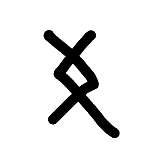

(128, 128, 4)


In [62]:
#change the color to gray picture
from skimage.color import rgb2gray
path = './MLBD-dataset-IML-2022-Anglo-Saxion-Runes'
images_original = io.imread_collection(os.path.join(f'{path}/*.png'))
print(f'Number of images: {len(images_original)}')
display(images_original[0])
print(images_original[0].shape)

Creating a new dataframe with the labels and the image names separated.

In [93]:
dataset_grayscale = []
images_as_gray = []
for file_name in listdir(path):
    full_path = join(path, file_name)
    if isfile(full_path):
        if re.match(r".*\.png$", full_path):
            image_current = io.imread(full_path, as_gray=True)
            image_label = file_name.split('_')[0].lower()
            image_number = file_name.split('_')[2].lower() + "_" + file_name.split('_')[3].lower()
            
            image_definition = [image_current, image_number, image_label]
            
            dataset_grayscale.append(image_definition)

labeled_images = pd.DataFrame(dataset_grayscale, columns=["image", "rune_id", "label"])

In [94]:
labeled_images.head(10)

,image,rune_id,label
0,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...",160547_2025030270.png,ash
1,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...",160547_2549270937.png,ash
2,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...",160547_3669898631.png,ash
3,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...",160547_4105113150.png,ash
4,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...",160547_4272441664.png,ash
5,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...",160547_4538430006.png,ash
6,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...",160547_7060350912.png,ash
7,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...",160547_7724475204.png,ash
8,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...",160547_8403188040.png,ash
9,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...",160547_9446549830.png,ash


As we can see now, the images are stored as numpy arrays grayscale with 128x128 pixels and contains the rune id and the label as well.

Number of images in dataset 3030
Shape (128, 128)
Numpy Array [[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
Rune id 161206_2085017735.png
Label ash


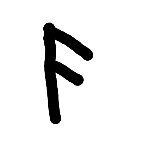

In [95]:
print('Number of images in dataset', len(dataset_grayscale))
print('Shape', dataset_grayscale[200][0].shape)
print('Numpy Array', dataset_grayscale[200][0])
print('Rune id', dataset_grayscale[200][1])
print('Label', dataset_grayscale[200][2])
display(dataset_grayscale[200][0])


In [98]:
print(labeled_images['image'].shape)
print(type(labeled_images['image']))

(3030,)
<class 'pandas.core.series.Series'>


As it is stated into the the assignment we are going to experiment with different network structures. 

Therefore, we would have to:

- Experiment with at least 6 different network structures with minimum of 2 convolutional layers per network.
- Difference with and without dropout.


In [99]:
BATCH_SIZE = 128
EPOCHS = 10
IMG_SIZE = (128, 128)

In [43]:
# images_original_np_array = np.array(images_original)
# labels_fit_transform = LabelEncoder().fit_transform(labeled_images['label'])
# data_set_categorial = tf.keras.utils.to_categorical(labels_fit_transform)

In [100]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dataset_grayscale[:][0], dataset_grayscale[:][2], test_size=0.2, random_state=123)

In [101]:
np.unique(y_train, return_counts=True)

(array(['160547_3669898631.png', 'ash'], dtype='<U21'),
 array([1, 1], dtype=int64))

In [89]:
def display_runes(runes, labels):
    plt.figure(figsize=(20, 20))
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(runes[i], cmap=plt.cm.binary)
        plt.xlabel(labels[i])
    plt.show()


As the slides are saying, the convolutional layers are used to extract features from the images.
We are going to define a function that will create this for us.

Keras layers engine contains an implementation of the convolutional layer
- Filters = number of filters you want to apply (= number of outputs)
- Kernel size = size of the weights kernel
- Padding = "valid" (don't pad) or "same" (output size equal to input size)
- Strides = stride step size for vertical and horizontal

In [102]:
def define_conv_layers(model, kernel_size=(3,3), pool_size=(2,2), activation='relu', dropout=0.25):
    model.add(keras.layers.Conv2D(32, kernel_size, padding='same', input_shape=(128, 128, 3)))
    model.add(keras.layers.Activation(activation))
    model.add(keras.layers.MaxPooling2D(pool_size=pool_size))
    model.add(keras.layers.Dropout(0.25))

    model.add(keras.layers.Conv2D(64, kernel_size, padding='same'))
    model.add(keras.layers.Activation(activation))
    model.add(keras.layers.Conv2D(64, kernel_size))
    model.add(keras.layers.Activation(activation))
    model.add(keras.layers.MaxPooling2D(pool_size=pool_size))
    model.add(keras.layers.Dropout(0.25))

    # model.add(keras.layers.Conv2D(128, kernel_size, padding='same'))
    # model.add(keras.layers.Activation(activation))
    # model.add(keras.layers.Conv2D(128, kernel_size))
    # model.add(keras.layers.Activation(activation))
    # model.add(keras.layers.MaxPooling2D(pool_size=pool_size))
    # model.add(keras.layers.Dropout(0.25))

    # model.add(keras.layers.Flatten())
    # model.add(keras.layers.Dense(512))
    # model.add(keras.layers.Activation(activation))
    # model.add(keras.layers.Dropout(0.5))
    # model.add(keras.layers.Dense(25))
    # model.add(keras.layers.Activation('softmax'))

    return model

In [121]:
def create_model():
    model = keras.Sequential()
    model = define_conv_layers(model)
    # Define the fully connected layer
    model.add(tf.keras.layers.Dense(512, activation='relu'))

    # Define the output layer
    model.add(tf.keras.layers.Dense(11, activation='softmax'))
    
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    # print model layers
    # model.summary()
    return model

In [144]:
def create_fit_model(input_data, output_data, layers=[], optimizer="adam", endActi="softmax", batchSize=50, epochs=10, verbose=0, withHistory=0):
    model = create_model()

#     inputNeurons = input_data.shape[1]
    outputNeurons = 11

    # output_data = output_data.values.reshape(-1,1)
    # print(output_data[:][2])
    # encoder = LabelEncoder().fit_transform(output_data[:][2])
    # output_data = tf.keras.utils.to_categorical(output_data, outputNeurons)
    y_test_categorical = tf.keras.utils.to_categorical(y_test, outputNeurons)
    
    history = History()
    history = model.fit(input_data, 
                        y=output_data, 
                        batch_size=batchSize,
                        epochs=epochs, 
                        # verbose=verbose, 
                        shuffle=True, 
                        # validation_data=(X_test, y_test_categorical), 
                        #                  callbacks=[history]
                                                    )
    if withHistory == 1:
            return model, history
    return model

In [145]:
def plot_acc_loss(history):
    plt.figure(figsize=(20,8))
    
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    plt.show()

In [146]:
# def create_model(input_data, learningRate = 0.03, optimizer="adam", loss_function='categorical_crossentropy', activation_function="softmax"):
#     # Define the input layer
#     input_layer = tf.keras.layers.Input(shape=IMG_SIZE) # 4 channels of RGB

#     # Define the convolutional layers
#     conv_layer_1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(input_layer)
#     pooling_layer_1 = tf.keras.layers.MaxPooling2D((2, 2))(conv_layer_1)
#     conv_layer_2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(pooling_layer_1)
#     pooling_layer_2 = tf.keras.layers.MaxPooling2D((2, 2))(conv_layer_2)
#     conv_layer_3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(pooling_layer_2)
#     pooling_layer_3 = tf.keras.layers.MaxPooling2D((2, 2))(conv_layer_3)

#     # Flatten the output from the convolutional layers
#     flattened_layer = tf.keras.layers.Flatten()(pooling_layer_3)

#     # Define the fully connected layer
#     fc_layer = tf.keras.layers.Dense(512, activation='relu')(flattened_layer)

#     # Define the output layer
#     output_layer = tf.keras.layers.Dense(11, activation='softmax')(fc_layer)

#     # Create the model
#     model = tf.keras.Model(input_layer, output_layer)

#     # Compile the model
#     model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'], sample_weight_mode="temporary")
#     return model

In [147]:
model, history = create_fit_model(input_data=X_train, output_data=y_train, layers=[], optimizer="adam", endActi="softmax", batchSize=16, epochs=200, verbose=0, withHistory=1)
plot_acc_loss(history)

Epoch 1/200


ValueError: in user code:

    File "c:\Software\Anaconda\envs\project-bdt\lib\site-packages\keras\engine\training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "c:\Software\Anaconda\envs\project-bdt\lib\site-packages\keras\engine\training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Software\Anaconda\envs\project-bdt\lib\site-packages\keras\engine\training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "c:\Software\Anaconda\envs\project-bdt\lib\site-packages\keras\engine\training.py", line 859, in train_step
        y_pred = self(x, training=True)
    File "c:\Software\Anaconda\envs\project-bdt\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Software\Anaconda\envs\project-bdt\lib\site-packages\keras\engine\input_spec.py", line 228, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" '

    ValueError: Exception encountered when calling layer "sequential_13" (type Sequential).
    
    Input 0 of layer "conv2d_54" is incompatible with the layer: expected min_ndim=4, found ndim=1. Full shape received: (None,)
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(None,), dtype=string)
      • training=True
      • mask=None


In [46]:
model.fit(X_train, y_train, epochs=EPOCHS)


Epoch 1/10
76/76 [==============================] - 25s 327ms/step - loss: 0.2184 - accuracy: 0.9344
Epoch 2/10
76/76 [==============================] - 32s 427ms/step - loss: 0.1194 - accuracy: 0.9620
Epoch 3/10
76/76 [==============================] - 32s 422ms/step - loss: 0.0753 - accuracy: 0.9736
Epoch 4/10
76/76 [==============================] - 35s 458ms/step - loss: 0.0526 - accuracy: 0.9823
Epoch 5/10
76/76 [==============================] - 37s 482ms/step - loss: 0.0662 - accuracy: 0.9814
Epoch 6/10
76/76 [==============================] - 40s 531ms/step - loss: 0.0383 - accuracy: 0.9897
Epoch 7/10
76/76 [==============================] - 47s 620ms/step - loss: 0.0424 - accuracy: 0.9843
Epoch 8/10
76/76 [==============================] - 36s 464ms/step - loss: 0.0460 - accuracy: 0.9864
Epoch 9/10
76/76 [==============================] - 51s 677ms/step - loss: 0.1051 - accuracy: 0.9707
Epoch 10/10
76/76 [==============================] - 31s 405ms/step - loss: 0.1376 - accura

Train and validate the model

Visualize the results